In [26]:
import pystac_client
import geogif
import stackstac
import os
import math
import stackstac
import webbrowser

In [27]:
def polygon_to_bbox(geom):
    """
    Converte un GeoJSON Polygon in una bounding box (min_lon, min_lat, max_lon, max_lat).
    
    Parameters:
    - geom (dict): dizionario GeoJSON contenente un poligono
    
    Returns:
    - tuple: bounding box (min_lon, min_lat, max_lon, max_lat)
    """
    if geom["type"] != "Polygon":
        raise ValueError("Solo poligoni supportati.")

    coords = geom["coordinates"][0]  # lista di coordinate [lon, lat]

    lons = [point[0] for point in coords]
    lats = [point[1] for point in coords]

    min_lon = min(lons)
    max_lon = max(lons)
    min_lat = min(lats)
    max_lat = max(lats)

    return (min_lon, min_lat, max_lon, max_lat)

In [28]:
def create_microareas_grid(bbox, max_area_km2):
    """
    Divide una bounding box in microaree rettangolari di dimensione massima circa max_area_km2.

    Args:
        bbox (tuple): (min_lon, min_lat, max_lon, max_lat)
        max_area_km2 (float): area massima per microarea in km².

    Returns:
        dict: dizionario con chiavi 'micro_1', 'micro_2', ..., e valori bbox (min_lon, min_lat, max_lon, max_lat)
    """
    min_lon, min_lat, max_lon, max_lat = bbox

    # Calcolo latitudine media per correggere la lunghezza dei gradi di longitudine
    mean_lat = (min_lat + max_lat) / 2
    km_per_deg_lat = 111  # circa costante
    km_per_deg_lon = 111 * math.cos(math.radians(mean_lat))

    # Dimensioni della bounding box in km
    width_km = (max_lon - min_lon) * km_per_deg_lon
    height_km = (max_lat - min_lat) * km_per_deg_lat

    total_area_km2 = width_km * height_km

    # Numero stimato di microaree
    num_microareas = math.ceil(total_area_km2 / max_area_km2)

    # Calcolo righe e colonne approssimative
    n_cols = math.ceil(math.sqrt(num_microareas * (width_km / height_km)))
    n_rows = math.ceil(num_microareas / n_cols)

    lon_step = (max_lon - min_lon) / n_cols
    lat_step = (max_lat - min_lat) / n_rows

    microareas = {}
    count = 1

    for i in range(n_rows):
        for j in range(n_cols):
            cell_min_lon = min_lon + j * lon_step
            cell_max_lon = cell_min_lon + lon_step
            cell_min_lat = min_lat + i * lat_step
            cell_max_lat = cell_min_lat + lat_step

            microareas[f"micro_{count}"] = (
                cell_min_lon,
                cell_min_lat,
                cell_max_lon,
                cell_max_lat
            )
            count += 1

    return microareas

In [29]:
def create_microareas_bbox_and_geom(bbox, max_area_km2):
    """
    Chiama create_microareas_grid per creare una bounding box in microaree rettangolari
    e restituisce le bounding box delle micro aree e i rispettivi poligoni GeoJSON.

    Args:
        bbox (tuple): (min_lon, min_lat, max_lon, max_lat)
        max_area_km2 (float): area massima per microarea in km².

    Returns:
        dict: dizionario con chiavi 'micro_1', 'micro_2', ..., e valori GeoJSON Polygon
    """
    microareas_bbox = create_microareas_grid(bbox, max_area_km2)
    microareas_geom = {}

    for key, (min_lon, min_lat, max_lon, max_lat) in microareas_bbox.items():
        polygon = {
            "type": "Polygon",
            "coordinates": [[
                [min_lon, min_lat],
                [min_lon, max_lat],
                [max_lon, max_lat],
                [max_lon, min_lat],
                [min_lon, min_lat]
            ]]
        }
        microareas_geom[key] = polygon

    return microareas_bbox, microareas_geom

In [30]:
os.environ["GDAL_HTTP_TCP_KEEPALIVE"] = "YES"
os.environ["AWS_S3_ENDPOINT"] = "eodata.dataspace.copernicus.eu"
os.environ["AWS_ACCESS_KEY_ID"] = "SDSQGA6TB9ELDPDK6DS6"  # !
os.environ["AWS_SECRET_ACCESS_KEY"] = "TIpYjNjNhErjIWAZIs2wOWCXQZlr0LRkO1c9QybW"  # !
os.environ["AWS_HTTPS"] = "YES"
os.environ["AWS_VIRTUAL_HOSTING"] = "FALSE"
os.environ["GDAL_HTTP_UNSAFESSL"] = "YES"

In [31]:
URL = "https://stac.dataspace.copernicus.eu/v1"
cat = pystac_client.Client.open(URL)
cat.add_conforms_to("ITEM_SEARCH")

In [32]:
macro_geom = {"type":"Polygon","coordinates":[[[-124.244385,41.779505],[-121.129761,41.779505],[-121.05835,39.60992],[-124.442139,39.614152],[-124.464111,41.779505],[-124.244385,41.779505]]]}
macro_bbox = polygon_to_bbox(macro_geom)
microareas_bbox, microareas_geom = create_microareas_bbox_and_geom(macro_bbox, 1000)
microarea_example_bbox = microareas_bbox['micro_55']
microarea_example_geom  = microareas_geom['micro_55']

In [33]:
microareas_bbox

{'micro_1': (-124.464111, 39.60992, -124.12353490000001, 39.91986071428572),
 'micro_2': (-124.12353490000001,
  39.60992,
  -123.78295880000002,
  39.91986071428572),
 'micro_3': (-123.7829588, 39.60992, -123.4423827, 39.91986071428572),
 'micro_4': (-123.4423827, 39.60992, -123.1018066, 39.91986071428572),
 'micro_5': (-123.1018066, 39.60992, -122.76123050000001, 39.91986071428572),
 'micro_6': (-122.76123050000001,
  39.60992,
  -122.42065440000002,
  39.91986071428572),
 'micro_7': (-122.4206544, 39.60992, -122.0800783, 39.91986071428572),
 'micro_8': (-122.0800783, 39.60992, -121.7395022, 39.91986071428572),
 'micro_9': (-121.7395022, 39.60992, -121.39892610000001, 39.91986071428572),
 'micro_10': (-121.39892610000001,
  39.60992,
  -121.05835000000002,
  39.91986071428572),
 'micro_11': (-124.464111,
  39.91986071428572,
  -124.12353490000001,
  40.229801428571434),
 'micro_12': (-124.12353490000001,
  39.91986071428572,
  -123.78295880000002,
  40.229801428571434),
 'micro_13': 

In [34]:
params = {
    "max_items": 100,
    "collections": "sentinel-2-l2a",
    "datetime": "2024-02-01/2024-10-01",
    "intersects": microarea_example_geom,
    "query": {"eo:cloud_cover": {"gte": 0, "lte": 20}},
    "sortby": "properties.eo:cloud_cover",
    "fields": {"exclude": ["geometry"]},
}

In [35]:
items = list(cat.search(**params).items_as_dicts())

In [36]:
stack = stackstac.stack(
    items=items,
    resolution=(60, 60),
    bounds_latlon=microarea_example_bbox,
    chunksize=98304,
    epsg=32634,
    gdal_env=stackstac.DEFAULT_GDAL_ENV.updated(
        {
            "GDAL_NUM_THREADS": -1,
            "GDAL_HTTP_UNSAFESSL": "YES",
            "GDAL_HTTP_TCP_KEEPALIVE": "YES",
            "AWS_VIRTUAL_HOSTING": "FALSE",
            "AWS_HTTPS": "YES",
        }
    ),
)

In [37]:
rgb = stack.sel(band=["B04_60m", "B03_60m", "B02_60m"])

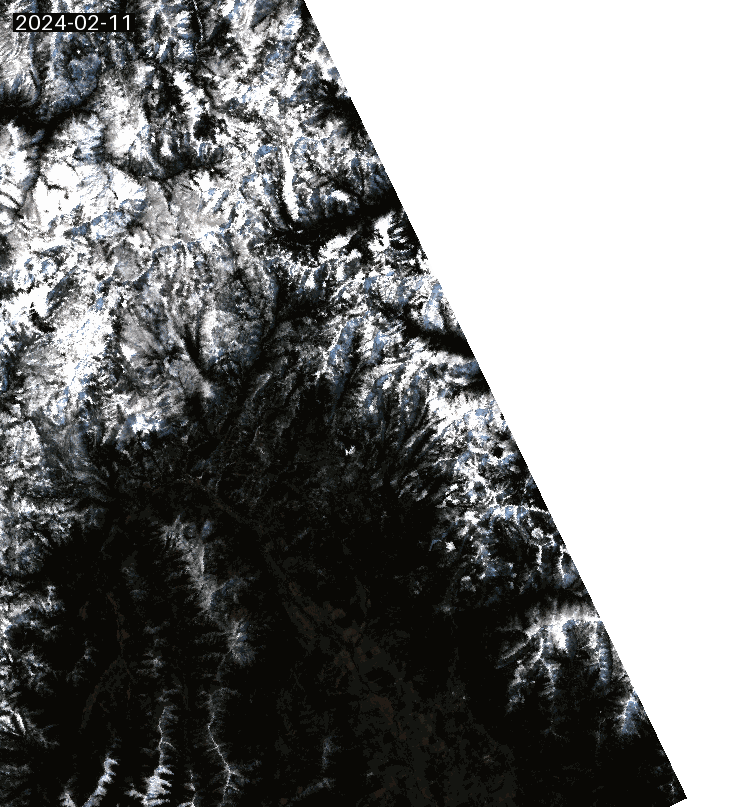

In [38]:
gif = geogif.dgif(rgb, fps=1).compute()
gif